# Working environnment

In [1]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization
from matplotlib.gridspec import GridSpec

# Feature engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

# Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing data
df_pred_txt = pd.read_pickle('df_pred_text.pkl')
df_pred_img = pd.read_pickle('CNN_prediction.pkl')

# Creating a dataset containing all probabilities and results
data = df_pred_txt.join(df_pred_img)

In [3]:
# Function for plotting scores
def plot_report(y_true, y_pred, class_names, title = ""):
    fig = plt.figure(figsize = (15,5))
    fig.suptitle(title, fontweight = 'heavy')
    gs = fig.add_gridspec(1,2, width_ratios = [1,2])
    ax1 = fig.add_subplot(gs[1])
    ax2 = fig.add_subplot(gs[0])
    
    # Plot classification report
    report = classification_report(y_true, y_pred, output_dict = True, target_names = class_names)
    df_report = pd.DataFrame(report).iloc[:2,:7]
    acc = round(100*report['accuracy'],1)
    
    df_report.T.plot(kind = 'bar', rot = 30, ax = ax1)
    ax1.set_title('Classification report (accuracy = {}%)'.format(acc), fontweight = 'demibold', fontsize = 10)
    ax1.set_xticklabels(class_names, rotation = 30, horizontalalignment = 'right')
    ax1.grid(True)
    
    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.subplot(ax2)
    sns.heatmap(conf_matrix, cmap = 'RdYlGn', annot = True, square = True, 
                cbar = False, xticklabels = class_names, yticklabels = class_names)
    ax2.set_title('Confusion matrix', fontweight = 'demibold', fontsize = 10)
    ax2.set_xticklabels(class_names, rotation = 30, horizontalalignment = 'right')
    plt.show()

# Predictions based on both models

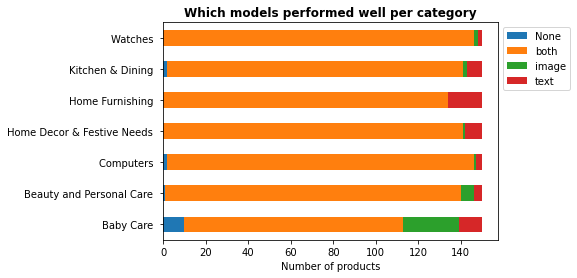

In [4]:
# Share of categories correctly predicted by both models
le = LabelEncoder()
data['label'] = le.fit_transform(data['category'])
class_names = le.inverse_transform(range(7))

data['well_predicted'] = "None"
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] == data['label']) & (data['img_prediction'] == data['label']), other = 'both')
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] == data['label']) & (data['img_prediction'] != data['label']), other = 'text')
data['well_predicted'] = data['well_predicted'].mask((data['txt_prediction'] != data['label']) & (data['img_prediction'] == data['label']), other = 'image')

# Performance per category
df_gr_ = data.groupby(['category', 'well_predicted'], as_index = False).agg({'image' : 'count'})
df_gr_.pivot(index = 'category', columns = 'well_predicted', values = 'image').plot(kind = 'barh', stacked = True)
plt.title("Which models performed well per category", fontweight = 'bold')
plt.xlabel('Number of products')
plt.ylabel(None)
plt.legend(bbox_to_anchor = (1,1,0,0))
plt.show()

In [5]:
# Data preprocessing
features_columns = [x for x in data.columns if "p(C" in x]
X_ = data[features_columns]
y_ = data['label']

X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size = 0.35, random_state = 143)

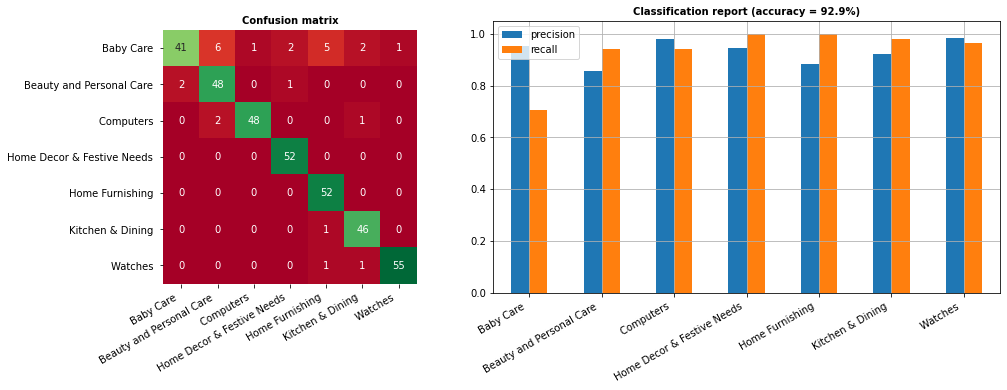

In [6]:
# Scoring report for text
plot_report(y_test, X_test[[x for x in data.columns if '|text' in x]].values.argmax(axis = 1), class_names)

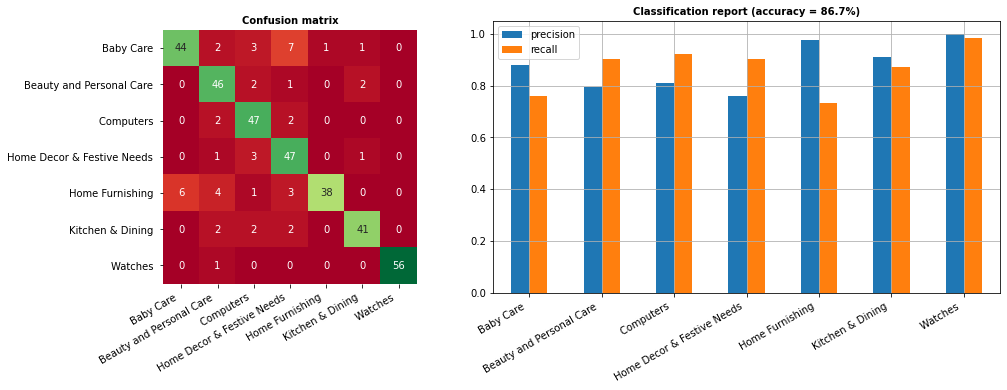

In [7]:
# Scoring report of images
plot_report(y_test, X_test[[x for x in data.columns if '|image' in x]].values.argmax(axis = 1), class_names)

## Perceptron

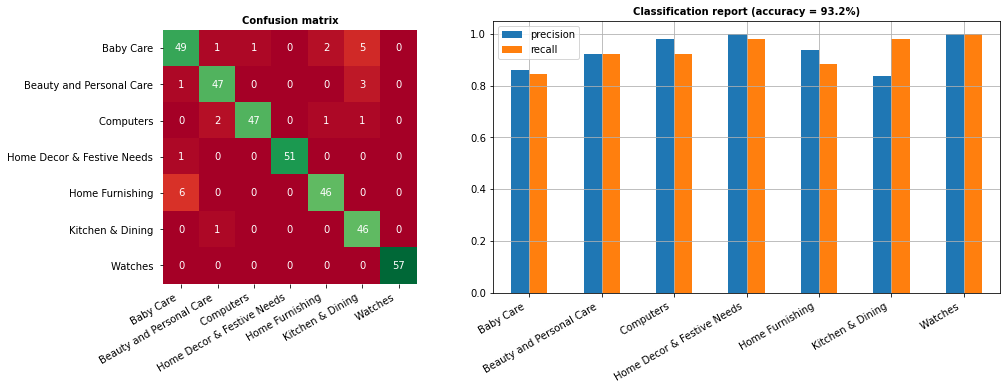

In [8]:
# Perceptron model
percep = Perceptron(validation_fraction = 0.2, max_iter = 5000, early_stopping = True, n_iter_no_change = 200, tol = 10**-5, penalty = 'l1')

percep.fit(X_train, y_train)
y_percep = percep.predict(X_test)

plot_report(y_test, y_percep, class_names = class_names)

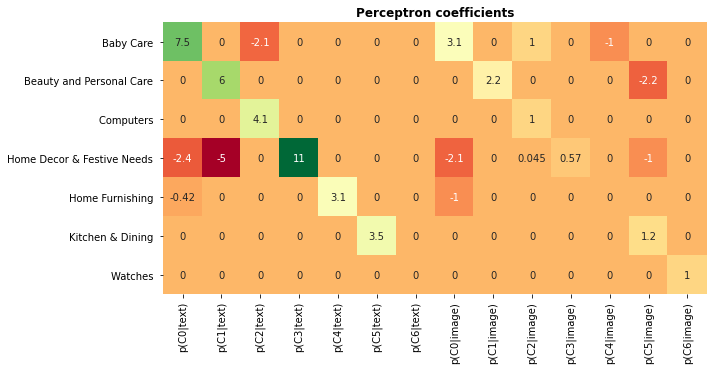

In [9]:
df_percep = pd.DataFrame(percep.coef_, index = class_names, columns = features_columns)
plt.figure(figsize = (25,5))
sns.heatmap(df_percep, cmap = 'RdYlGn', annot = True, square = True, cbar = False)
plt.title("Perceptron coefficients", fontweight = 'bold')
plt.show()

In [10]:
data_test = data.loc[y_test.index]
data_test['y_percep'] = le.inverse_transform(y_percep)
data_test[['image', 'category', 'y_percep']][y_test != y_percep].head()

,image,category,y_percep
383,54754ccd18f2a75c53de68806176392a.jpg,Computers,Home Furnishing
976,fa2e5f01bbb642c49e4b2e19d2b39dcf.jpg,Beauty and Personal Care,Kitchen & Dining
784,fb435889d257c924c7bf77396a555e04.jpg,Baby Care,Home Furnishing
477,721c1b67f86176f741d43cae1d1c7e93.jpg,Home Furnishing,Baby Care
785,29d7a1b4d4f658fc3082905f65e1b009.jpg,Baby Care,Beauty and Personal Care


In [11]:
data_test[['image', 'category', 'p(C2|text)', 'p(C2|image)', 'y_percep', 'p(C4|text)', 'p(C4|image)']][y_test != y_percep].head(1)

,image,category,p(C2|text),p(C2|image),y_percep,p(C4|text),p(C4|image)
383,54754ccd18f2a75c53de68806176392a.jpg,Computers,0.271565,2.586014e-10,Home Furnishing,0.108021,0.002027


In [12]:
data_test[['image', 'category', 'p(C1|text)', 'p(C1|image)', 'y_percep', 'p(C5|text)', 'p(C5|image)']][y_test != y_percep].iloc[1]

image          fa2e5f01bbb642c49e4b2e19d2b39dcf.jpg
category                  Beauty and Personal Care 
p(C1|text)                                 0.180217
p(C1|image)                             1.45208e-32
y_percep                          Kitchen & Dining 
p(C5|text)                                 0.179848
p(C5|image)                                       1
Name: 976, dtype: object

## Other models

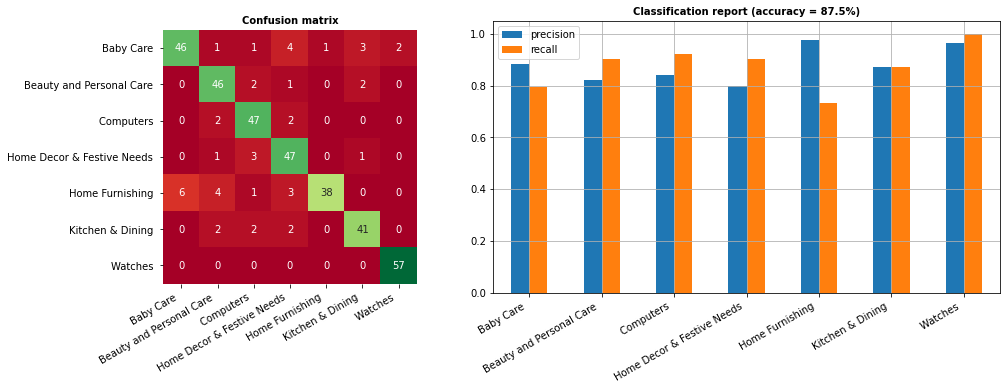

In [13]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (10, 10), max_iter = 5000, early_stopping = True, 
                    n_iter_no_change = 200, validation_fraction = 0.2, learning_rate = 'adaptive',
                    activation = 'relu')

mlp.fit(X_train, y_train)
y_mlp = mlp.predict(X_test)
plot_report(y_test, y_mlp, class_names = class_names)

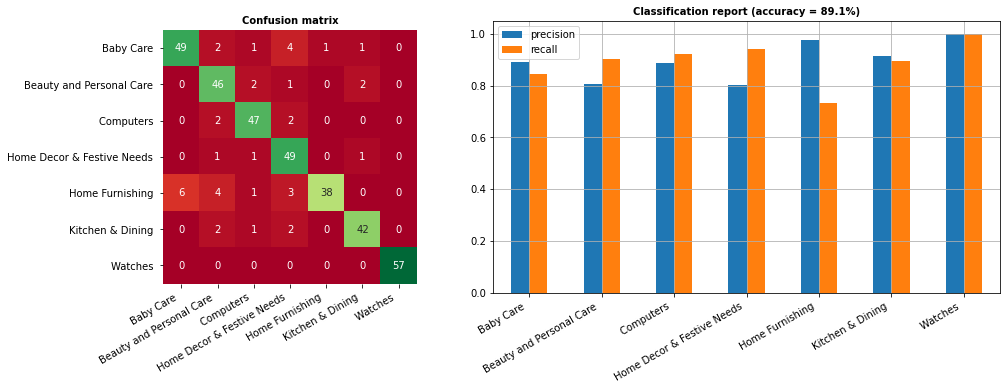

In [14]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
y_lsvc = lsvc.predict(X_test)
plot_report(y_test, y_lsvc, class_names = class_names)

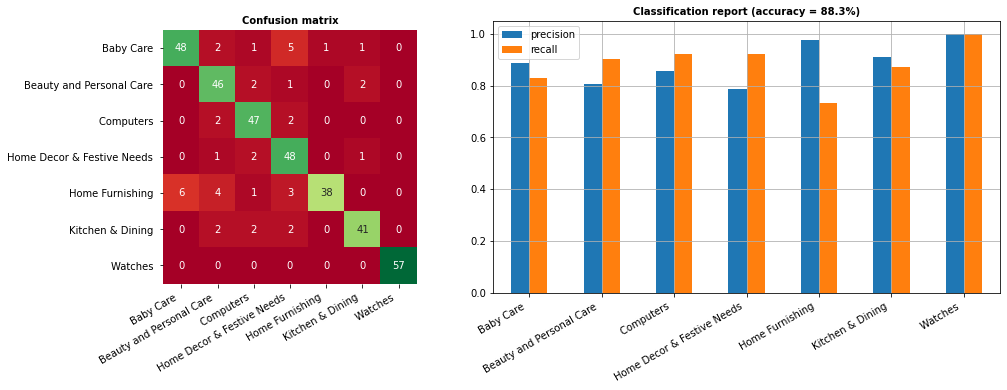

In [15]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
plot_report(y_test, y_svc, class_names = class_names)

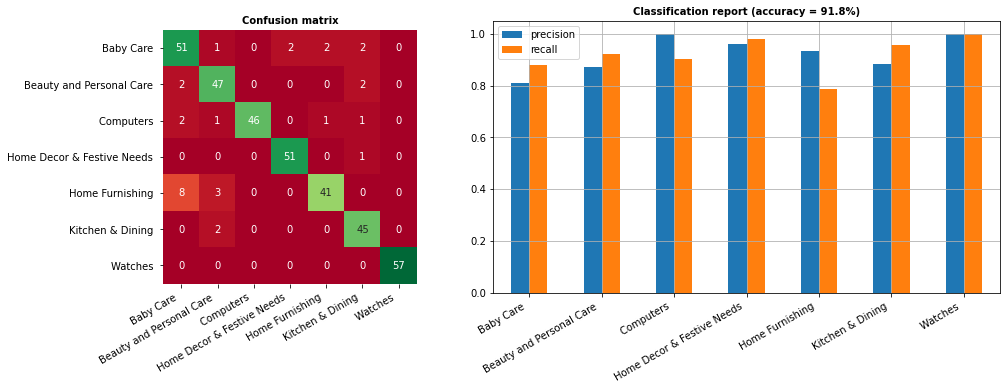

In [16]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
rfc = RandomForestClassifier(n_estimators = 500, max_depth = None, max_features = 'log2')
rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_test)
plot_report(y_test, y_rfc, class_names = class_names)

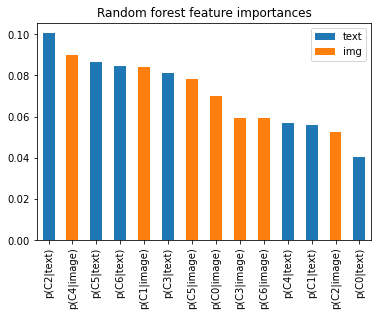

In [17]:
# Feature importances
df_fi_ = pd.DataFrame(rfc.feature_importances_, index = features_columns, columns = ['feature_importance'])
df_fi_.sort_values(by = 'feature_importance', ascending = False, inplace = True)
df_fi_['text'] = df_fi_['feature_importance'].where(df_fi_.index.str.contains('text'))
df_fi_['img'] = df_fi_['feature_importance'].where(df_fi_.index.str.contains('image'))

df_fi_.iloc[:,1:].plot(kind = 'bar', stacked = True)
plt.title('Random forest feature importances')
plt.show()

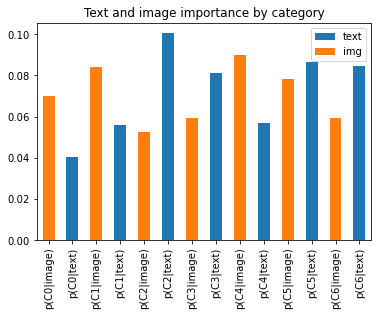

In [18]:
# Text and image importance by category
df_fi_.sort_index().iloc[:,1:].plot(kind = 'bar', stacked = True)
plt.title('Text and image importance by category')
plt.show()

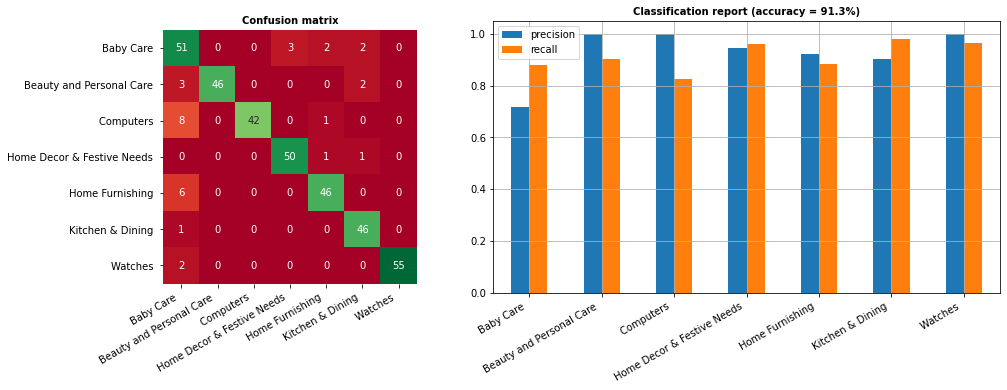

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_gbc = gbc.predict(X_test)
plot_report(y_test, y_gbc, class_names = class_names)

## With Scaling

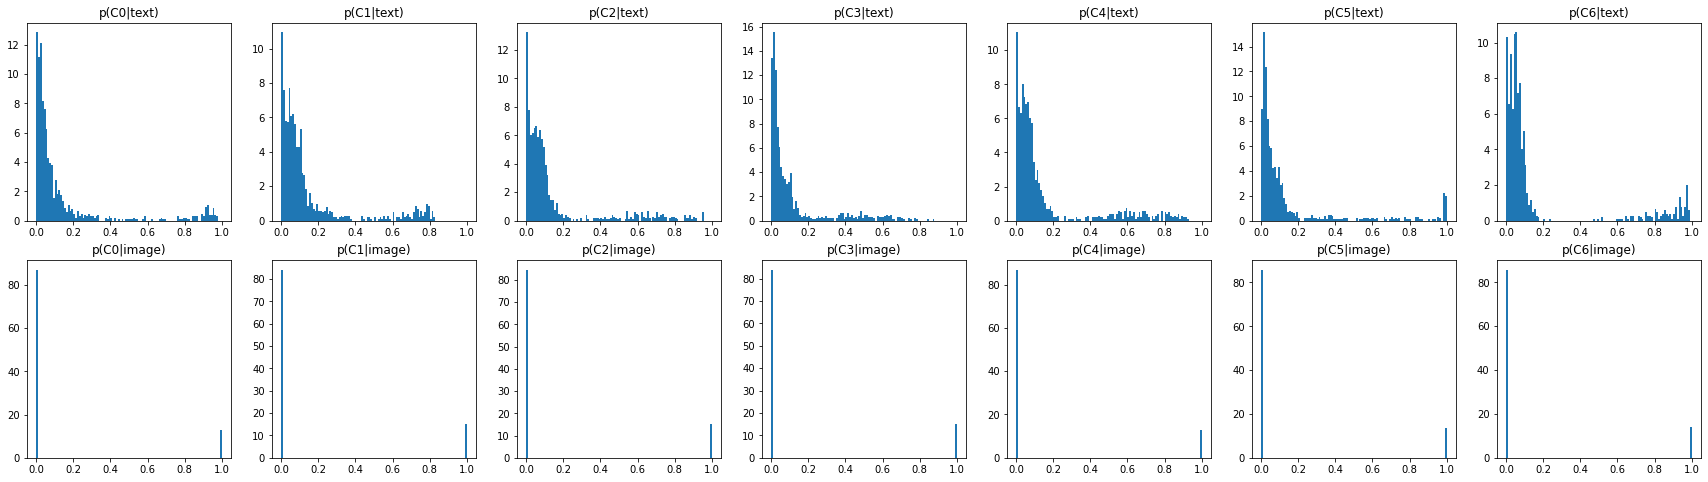

In [20]:
plt.figure(figsize = (30,8))

for i,c in enumerate(features_columns):
    plt.subplot(2,7,i+1)
    plt.hist(data[c], bins = np.arange(0,1.01, 0.01), density = True)
    plt.title(c)
plt.show()

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

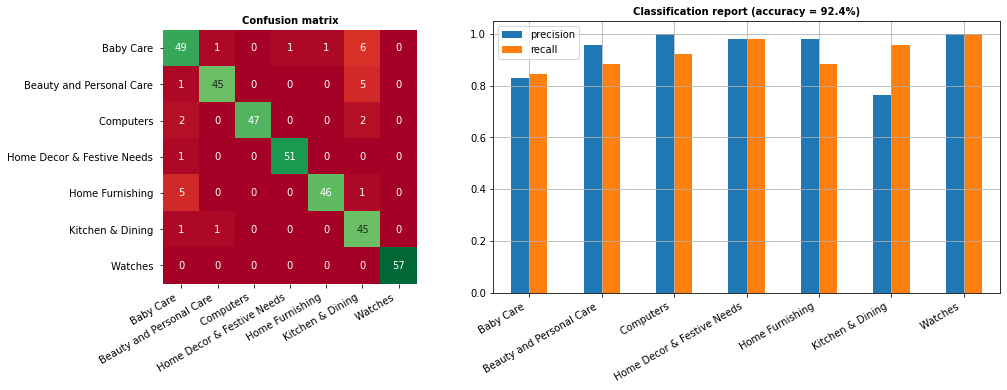

In [22]:
# Perceptron model
percep = Perceptron(validation_fraction = 0.2, max_iter = 1000, early_stopping = True, n_iter_no_change = 200, tol = 10**-5, penalty = 'l1')

percep.fit(X_train_scaled, y_train)
y_percep = percep.predict(X_test_scaled)

plot_report(y_test, y_percep, class_names = class_names)

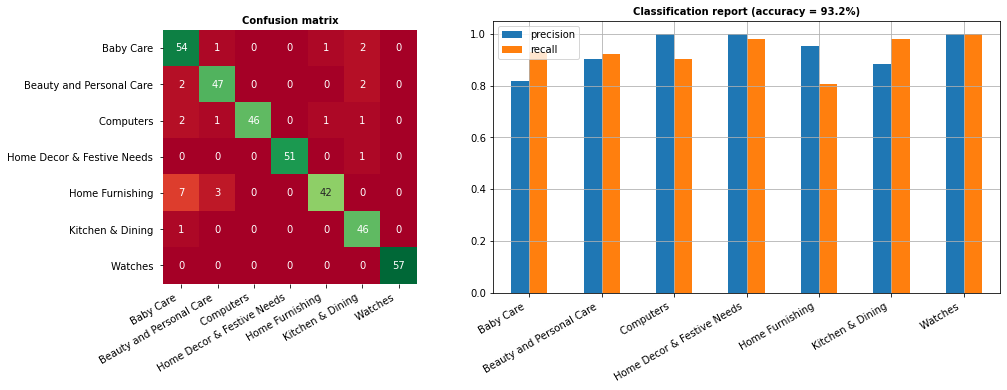

In [23]:
rfc = RandomForestClassifier(n_estimators = 500, max_depth = None, max_features = 'log2')
rfc.fit(X_train_scaled, y_train)
y_rfc = rfc.predict(X_test_scaled)
plot_report(y_test, y_rfc, class_names = class_names)

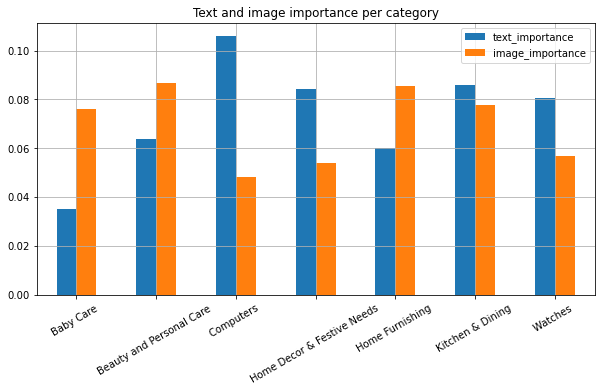

In [24]:
# Feature importance per category
df_fi_ = pd.DataFrame([rfc.feature_importances_[:7], rfc.feature_importances_[7:]],
                     index = ['text_importance', 'image_importance'],
                     columns = class_names).T

df_fi_.plot(kind = 'bar', figsize = (10,5), rot = 30)
plt.title('Text and image importance per category')
plt.grid()
plt.show()